# PREPROCESSING

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [116]:
df = pd.read_csv("pengeluaran.csv")
df.head()

,id_pengeluaran,id_user,kategori,jumlah,tanggal
0,1,1,Makanan dan Minuman,10000,1/4/2024
1,2,1,Makanan dan Minuman,12000,1/4/2024
2,3,1,Paket Internet,50000,1/4/2024
3,4,1,Kos,500000,1/4/2024
4,5,1,Makanan dan Minuman,15000,2/4/2024


In [117]:
df.drop(columns=['id_pengeluaran', 'id_user'], inplace=True)
df.head()

,kategori,jumlah,tanggal
0,Makanan dan Minuman,10000,1/4/2024
1,Makanan dan Minuman,12000,1/4/2024
2,Paket Internet,50000,1/4/2024
3,Kos,500000,1/4/2024
4,Makanan dan Minuman,15000,2/4/2024


In [118]:
# konversi kolom tanggal ke datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], format='%d/%m/%Y')

## AGREGASI HARIAN

In [119]:
# Agregasi data: total pengeluaran per hari
daily_expense = df.groupby('tanggal')['jumlah'].sum().reset_index()
daily_expense

,tanggal,jumlah
0,2024-04-01,572000
1,2024-04-02,25000
2,2024-04-03,21000
3,2024-04-04,25000
4,2024-04-05,12000
...,...,...
389,2025-04-26,26000
390,2025-04-27,22000
391,2025-04-28,27000
392,2025-04-29,20000


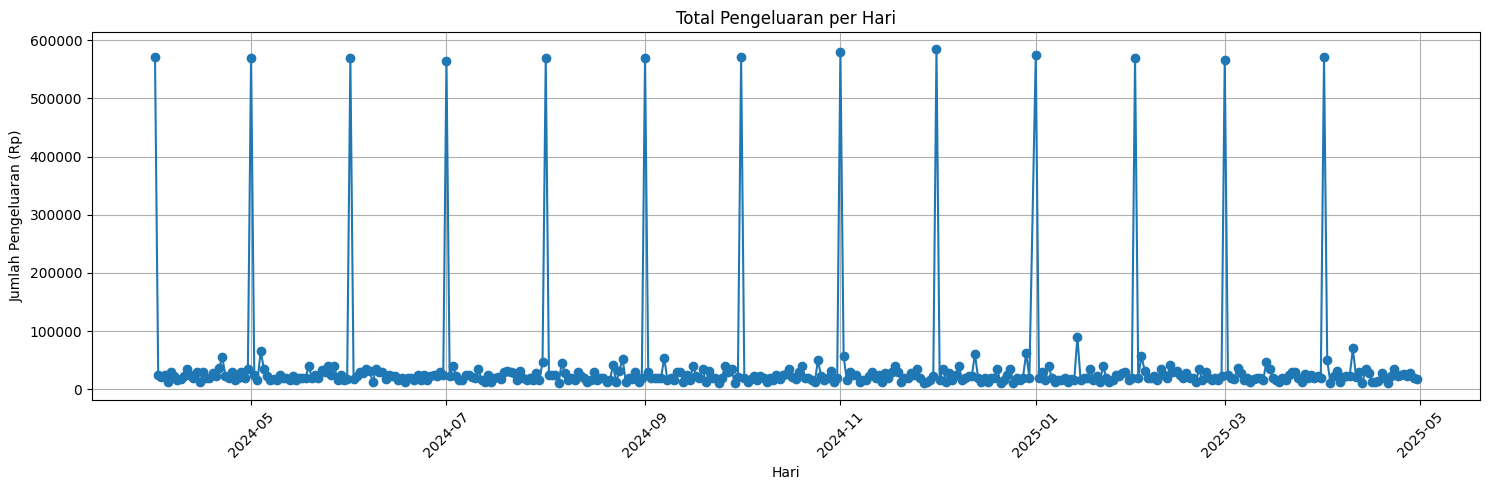

In [120]:
# Plot pengeluaran per hari
plt.figure(figsize=(15, 5))
plt.plot(daily_expense['tanggal'], daily_expense['jumlah'], marker='o', linestyle='-')
plt.title('Total Pengeluaran per Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Pengeluaran (Rp)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## AGREGASI BULANAN

In [121]:
# Agregasi data: total pengeluaran per bulan
monthly_expense = df.groupby(df["tanggal"].dt.to_period("M"))["jumlah"].sum().reset_index()

monthly_expense['month'] = monthly_expense['tanggal'].dt.to_timestamp()
monthly_expense

,tanggal,jumlah,month
0,2024-04,1285000,2024-04-01
1,2024-05,1299000,2024-05-01
2,2024-06,1233000,2024-06-01
3,2024-07,1252000,2024-07-01
4,2024-08,1236000,2024-08-01
5,2024-09,1263000,2024-09-01
6,2024-10,1222000,2024-10-01
7,2024-11,1248000,2024-11-01
8,2024-12,1264000,2024-12-01
9,2025-01,1261000,2025-01-01


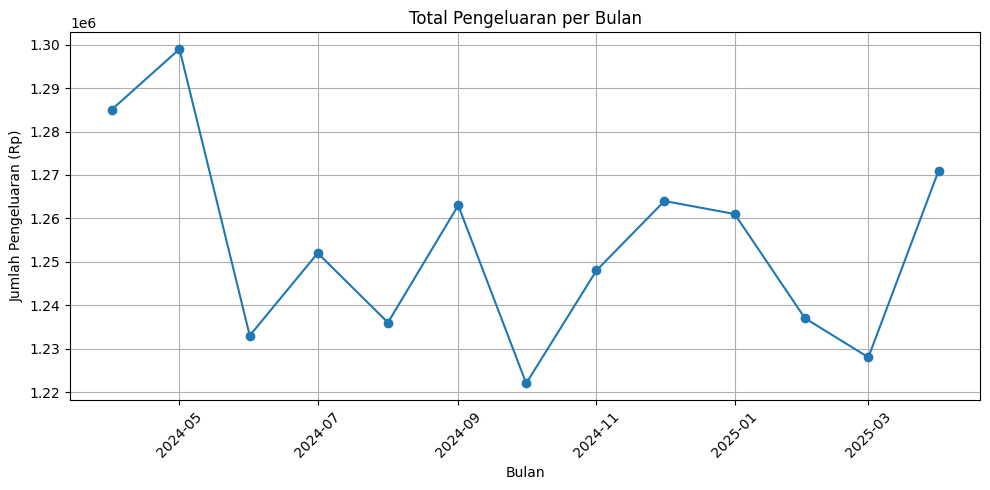

In [122]:
# Plot pengeluaran per bulan
plt.figure(figsize=(10, 5))
plt.plot(monthly_expense['month'], monthly_expense['jumlah'], marker='o', linestyle='-')
plt.title('Total Pengeluaran per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pengeluaran (Rp)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
monthly_expense.describe()

,jumlah,month
count,1.300000e+01,13
mean,1.253769e+06,2024-09-30 22:09:13.846153728
min,1.222000e+06,2024-04-01 00:00:00
25%,1.236000e+06,2024-07-01 00:00:00
50%,1.252000e+06,2024-10-01 00:00:00
75%,1.264000e+06,2025-01-01 00:00:00
max,1.299000e+06,2025-04-01 00:00:00
std,2.290980e+04,NaN


# SPLITTING DATA

In [124]:
# Set index ke datetime (diperlukan untuk ARIMA)
monthly_expense.set_index('month', inplace=True)

train = monthly_expense.iloc[:-1]
test = monthly_expense.iloc[-1:]

print(train)
print(test)

            tanggal   jumlah
month                       
2024-04-01  2024-04  1285000
2024-05-01  2024-05  1299000
2024-06-01  2024-06  1233000
2024-07-01  2024-07  1252000
2024-08-01  2024-08  1236000
2024-09-01  2024-09  1263000
2024-10-01  2024-10  1222000
2024-11-01  2024-11  1248000
2024-12-01  2024-12  1264000
2025-01-01  2025-01  1261000
2025-02-01  2025-02  1237000
2025-03-01  2025-03  1228000
            tanggal   jumlah
month                       
2025-04-01  2025-04  1271000


# BASELINE MODEL

In [125]:
# ==== ARIMA ====
model_arima = ARIMA(train['jumlah'], order=(1,1,1))
fit_arima = model_arima.fit()
pred_train_arima = fit_arima.predict(start=train.index[1], end=train.index[-1])
pred_test_arima = fit_arima.forecast(steps=1)

rmse_train_arima = np.sqrt(mean_squared_error(train['jumlah'][1:], pred_train_arima))
rmse_test_arima = np.sqrt(mean_squared_error(test['jumlah'], pred_test_arima))

print(f"RMSE Train ARIMA: {rmse_train_arima:.2f}")
print(f"RMSE Test ARIMA : {rmse_test_arima:.2f}")
print(f"Prediksi bulan berikutnya: Rp {pred_test_arima.iloc[0]:,.0f}")

RMSE Train ARIMA: 18986.34
RMSE Test ARIMA : 49804.08
Prediksi bulan berikutnya: Rp 1,221,196


In [126]:
# ==== SARIMA ====
model_sarima = SARIMAX(train['jumlah'], order=(1,1,1), seasonal_order=(1,1,1,3))
fit_sarima = model_sarima.fit()
pred_train_sarima = fit_sarima.predict(start=train.index[1], end=train.index[-1])
pred_test_sarima = fit_sarima.forecast(steps=1)

rmse_train_sarima = np.sqrt(mean_squared_error(train['jumlah'][1:], pred_train_sarima))
rmse_test_sarima = np.sqrt(mean_squared_error(test['jumlah'], pred_test_sarima))

print(f"RMSE Train SARIMA: {rmse_train_sarima:.2f}")
print(f"RMSE Test SARIMA : {rmse_test_sarima:.2f}")
print(f"Prediksi bulan berikutnya: Rp {pred_test_sarima.iloc[0]:,.0f}")

RMSE Train SARIMA: 392599.49
RMSE Test SARIMA : 75139.46
Prediksi bulan berikutnya: Rp 1,195,861


# GRID SEARCH

In [127]:
warnings.filterwarnings("ignore")

# Parameter grid untuk ARIMA (p, d, q)
p = d = q = range(0, 3) 
pdq = list(itertools.product(p, d, q))

best_score = float("inf")
best_cfg = None
results = []

y_train = train['jumlah']
y_test = test['jumlah']

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(y_test))
        
        mae = mean_absolute_error(y_test, forecast)
        rmse = mean_squared_error(y_test, forecast, squared=False)
        
        results.append((param, mae, rmse))
        
        if rmse < best_score:
            best_score = rmse
            best_cfg = param
            
    except Exception as e:
        print(f"Error dengan parameter {param}: {e}")
        continue

print(f"Best ARIMA order: {best_cfg} with RMSE: {best_score:.2f}\n")

results_df = pd.DataFrame(results, columns=["ARIMA_order", "MAE", "RMSE"])
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)
print(results_df.head())
print("\nBest config:", best_cfg)

Best ARIMA order: (1, 0, 2) with RMSE: 257.47

  ARIMA_order           MAE          RMSE
0   (1, 0, 2)    257.471708    257.471708
1   (0, 0, 2)   8358.878418   8358.878418
2   (2, 0, 2)   8387.532946   8387.532946
3   (2, 0, 1)  13641.754991  13641.754991
4   (1, 0, 1)  14134.651795  14134.651795

Best config: (1, 0, 2)


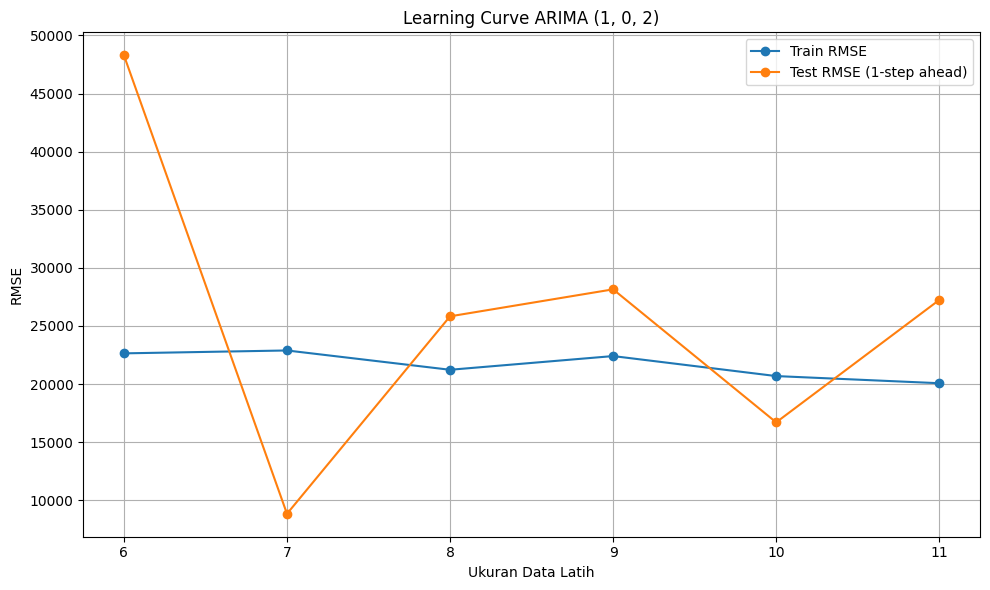

In [128]:
train_size = len(train)
min_size = 6  # jumlah minimum data latih

train_errors = []
test_errors = []

for i in range(min_size, train_size):
    y_train_subset = train['jumlah'][:i]
    y_test_true = train['jumlah'][i:i+1]  # data setelah subset untuk prediksi

    try:
        model = ARIMA(y_train_subset, order=best_cfg)
        model_fit = model.fit()

        # === Train RMSE ===
        pred_train = model_fit.predict(start=y_train_subset.index[1], end=y_train_subset.index[-1], typ='levels')
        rmse_train = mean_squared_error(y_train_subset[1:], pred_train, squared=False)

        # === Test RMSE (1-step forecast) ===
        y_pred_test = model_fit.forecast(steps=1)
        rmse_test = mean_squared_error(y_test_true, y_pred_test, squared=False)

        train_errors.append(rmse_train)
        test_errors.append(rmse_test)

    except Exception as e:
        print(f"Error pada i={i}: {e}")
        train_errors.append(np.nan)
        test_errors.append(np.nan)

# === Plot Learning Curve ===
plt.figure(figsize=(10, 6))
plt.plot(range(min_size, train_size), train_errors, label='Train RMSE', marker='o')
plt.plot(range(min_size, train_size), test_errors, label='Test RMSE (1-step ahead)', marker='o')
plt.title(f'Learning Curve ARIMA {best_cfg}')
plt.xlabel('Ukuran Data Latih')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
# Prediksi bulan selanjutnya (satu langkah ke depan)
model = ARIMA(train['jumlah'], order=best_cfg)
model_fit = model.fit()

forecast = model_fit.forecast(steps=1)
forecast_value = forecast.values[0]
forecast_date = test.index[0]
print(f"Prediksi bulan {forecast_date.strftime('%B %Y')}: Rp{forecast.iloc[0]:,.0f}")

Prediksi bulan April 2025: Rp1,271,257


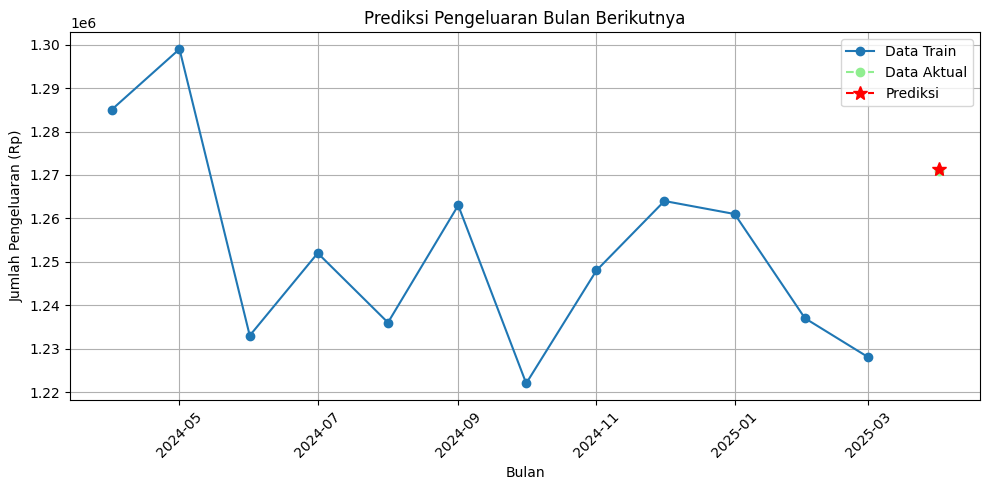

In [130]:
# Buat DataFrame untuk prediksi
forecast_df = pd.DataFrame({
    'jumlah': [forecast_value]
}, index=[forecast_date])

# Gabungkan semua data: train, test, dan prediksi
combined = pd.concat([train, test, forecast_df.rename(columns={'jumlah': 'forecast'})], axis=1)

# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['jumlah'], label='Data Train', marker='o')
plt.plot(test.index, test['jumlah'], label='Data Aktual', marker='o', linestyle='--', color='lightgreen')
plt.plot(forecast_df.index, forecast_df['jumlah'], label='Prediksi', marker='*', linestyle='--', markersize=10, color='red')
plt.title('Prediksi Pengeluaran Bulan Berikutnya')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pengeluaran (Rp)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Fit Ulang Seluruh Data

In [ ]:
# Gunakan seluruh data
full_data = monthly_expense['jumlah']

# Latih model dengan seluruh data
model = ARIMA(full_data, order=best_cfg)
model_fit = model.fit()

# Prediksi bulan berikutnya (1 langkah ke depan)
forecast = model_fit.forecast(steps=1)

# Tanggal bulan depan
forecast_date = monthly_expense.index[-1] + pd.DateOffset(months=1)
forecast_value = forecast.values[0]

print(f"Prediksi bulan {forecast_date.strftime('%B %Y')}: Rp{forecast_value:,.0f}")

Prediksi bulan May 2025: Rp1,259,888


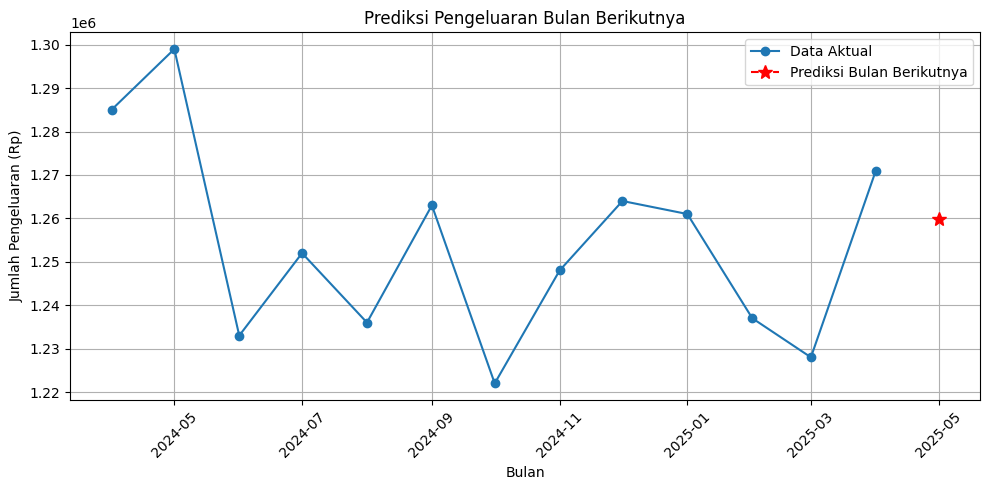

In [132]:
# Gabungkan hasil
forecast_df = pd.DataFrame({'jumlah': [forecast_value]}, index=[forecast_date])
combined = pd.concat([monthly_expense, forecast_df.rename(columns={'jumlah': 'forecast'})], axis=1)

plt.figure(figsize=(10, 5))

# Data historis (train + test)
plt.plot(monthly_expense.index, monthly_expense['jumlah'], label='Data Aktual', marker='o')

# Prediksi bulan depan
plt.plot(forecast_df.index, forecast_df['jumlah'], label='Prediksi Bulan Berikutnya', marker='*', linestyle='--', markersize=10, color='red')

plt.title('Prediksi Pengeluaran Bulan Berikutnya')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pengeluaran (Rp)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [133]:
import pickle

# Simpan model ke file
with open('model_arima.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

print("Model ARIMA berhasil disimpan ke 'model_arima.pkl'")

Model ARIMA berhasil disimpan ke 'model_arima.pkl'


In [134]:
# Load model dari file
with open('model_arima.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Gunakan untuk prediksi
forecast = loaded_model.forecast(steps=1)
print(f"Prediksi dengan model tersimpan: Rp{forecast[0]:,.0f}")

Prediksi dengan model tersimpan: Rp1,259,888


In [135]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools

In [136]:
def preprocess_data(df):
    """
    Melakukan preprocessing data pengeluaran:
    - konversi kolom tanggal ke datetime
    - agregasi jumlah pengeluaran per bulan
    - set index ke timestamp bulanan
    """
    df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')
    monthly = df.groupby(df['tanggal'].dt.to_period("M"))['jumlah'].sum().reset_index()
    monthly['month'] = monthly['tanggal'].dt.to_timestamp()
    monthly.set_index('month', inplace=True)
    return monthly

In [137]:
# import pandas as pd
# from datetime import datetime
# import pickle

# # === Fungsi Preprocessing ===
# def preprocess_data(csv_path):
#     df = pd.read_csv(csv_path)
#     df['tanggal'] = pd.to_datetime(df['tanggal'], format='%d/%m/%Y')
#     monthly_expense = df.groupby(df["tanggal"].dt.to_period("M"))["jumlah"].sum().reset_index()
#     monthly_expense['month'] = monthly_expense['tanggal'].dt.to_timestamp()
#     monthly_expense.set_index('month', inplace=True)
#     return df, monthly_expense

# # === Simulasi input user ===
# kategori_map = {
#     '1': 'Makanan dan Minuman',
#     '2': 'Transportasi',
#     '3': 'Kos',
#     '4': 'Lainnya',
#     '5': 'Kesehatan',
#     '6': 'Kebutuhan Akademik',
#     '7': 'Paket Internet'
# }

# print("Pilih kategori pengeluaran:")
# print("1. Makanan dan Minuman\n2. Transportasi\n3. Kos\n4. Lainnya\n5. Kesehatan\n6. Kebutuhan Akademik\n7. Paket Internet")
# kategori_input_num = input("Masukkan nomor kategori (1/2/3/4/5/6/7): ")

# if kategori_input_num not in kategori_map:
#     print("❌ Nomor kategori tidak valid.")
#     exit()

# kategori = kategori_map[kategori_input_num]

# try:
#     jumlah = float(input("Masukkan jumlah pengeluaran (Rp): "))
# except ValueError:
#     print("❌ Jumlah harus berupa angka.")
#     exit()

# id_user = 1  # diasumsikan tetap

# # === Path file ===
# csv_path = "C:/Users/lapto/Downloads/pengeluaran - Sheet1.csv"
# model_path = "model_arima.pkl"

# # === Baca CSV, tambah data baru, dan simpan ===
# df_existing = pd.read_csv(csv_path)
# today = datetime.today().strftime('%d/%m/%Y')
# new_id = df_existing['id_pengeluaran'].max() + 1 if not df_existing.empty else 1

# new_data = pd.DataFrame([{
#     'id_pengeluaran': new_id,
#     'id_user': id_user,
#     'kategori': kategori,
#     'jumlah': jumlah,
#     'tanggal': today
# }])

# df_updated = pd.concat([df_existing, new_data], ignore_index=True)
# df_updated.to_csv(csv_path, index=False)

# print(f"\n✅ Data baru berhasil ditambahkan:\n{new_data.to_string(index=False)}\n")

# # === Preprocessing ulang data terbaru ===
# df, monthly_expense = preprocess_data(csv_path)

# # === Prediksi dengan model ARIMA tersimpan ===
# with open(model_path, 'rb') as f:
#     loaded_model = pickle.load(f)

# forecast = loaded_model.forecast(steps=1)
# forecast_value = forecast[0]
# next_month = monthly_expense.index[-1] + pd.DateOffset(months=1)

# print(f"📅 Prediksi pengeluaran bulan {next_month.strftime('%B %Y')}: Rp{forecast_value:,.0f}")